# 15. 5th Attempt: Policy Gradient

여기서는
policy gradient를 적용해서 오목을 하는 policy network를
학습시켜봅니다.
이전까지 오목은 제대로 학습된 적이 없었으므로,
여기서는 주어진 agent를 상대로
적당한 시간, 적당한 게임 횟수 내에
유의미한 수준의 승률까지 학습을 시킬 수 있는지
가능성을 
확인하도록 합니다.

- Policy network는 모두 CNN으로만 구성합니다.
(오목 각 칸의 가치는 근처의 칸들에 의해 크게 결정된다는
가정과, dense layer가 있으면 parameter가 끔찍하게
많아지는 점 때문에 일단 이렇게 실험해봅니다.)
- 모든 layer가 convolutional layer이므로
입출력이 모두 2차원으로 나옵니다.
때문에 모든 칸은 절대적인 위치와 무관하게 주변의 정보로만
해당 위치의 가치를 추정하므로, 오목판의 크기가 신경망과
그다지 상관이 없습니다.
따라서 여기서는 오목판의 크기를 원래 오목 게임의 크기인
$15\times 15$로 맞춰두고 진행합니다.
- 특정 agent만을 사용하면 해당 agent에만 과적합이
되는 경우가 많으므로, 추가적인 analysis-based
agent를 추가시킵니다.
이후 승률 테스트를 할 때에는 각 agent와 맞붙여보지만,
학습 과정에서는 여러 agent의 행동을 랜덤으로 따라하는
mixed agent를 사용합니다.

### Environment

In [1]:
!rm -rf *
!git clone https://github.com/lumiknit/mock5.py
!mv mock5.py/mock5 .
!mv mock5.py/gen2_record/gen.cpp .
!mv mock5.py/gen2_record/read_record.py .
!g++ -O2 -fopenmp -o gen gen.cpp

Cloning into 'mock5.py'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 152 (delta 74), reused 121 (delta 47), pack-reused 0
Receiving objects: 100% (152/152), 40.18 KiB | 10.04 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [2]:
from mock5 import Mock5
from mock5.analysis import Analysis as M5Analysis
import mock5.agent_random as m5rand
import mock5.agent_analysis_based as m5aa
import mock5.agent_ad as m5ad
import mock5.agent_pt as m5pt
import mock5.agent_df as m5df

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: {}".format(device))

Device: cuda


### Board Size

In [3]:
# Board Size
W = 15
H = W

### Agent & Policy Transformer

Connect4나 오목 모두 1D Vector를 output으로
하므로, 이전에 사용했던 것에 크기만 바꿔서 재활용할 수 있습니다.

In [4]:
def softmax(arr, tau=1.0):
  arr = np.array(arr, dtype=np.float64)
  arr /= tau
  m = max(arr)
  z = np.exp(arr - m)
  return z / z.sum()

In [5]:
def fn_name(fn):
  if hasattr(fn, 'name'): return fn.name
  else: return repr(fn)

In [6]:
def agent(pi, epsilon=0):
  # pi must return array of non-negative values
  def c(game):
    w, h = game.width, game.height
    m, p = np.ones(h * w), np.array(pi(game))
    for i in range(h * w):
      if game.board[i] != 0: m[i], p[i] = 0, 0
    s = p.sum()
    if np.random.uniform() < epsilon or s == 0:
      s = m.sum()
      if s == 0: return None, None # Cannot do anything
      else: idx = np.random.choice(h * w, p=(m / s))
    else: idx = np.random.choice(h * w, p=(p / s))
    return idx // w, idx % w
  c.name = 'stochastic({})'.format(fn_name(pi))
  return c

In [7]:
def pt_softmax(policy, tau=1.0):
  def p(game):
    p = policy(game)
    return softmax(p, tau=tau)
  p.name = 'pt_softmax({},tau={})'.format(fn_name(policy), tau)
  return p

In [8]:
def pt_norm(policy):
  def p(game):
    p = policy(game)
    return p / p.max()
  p.name = 'pt_norm({})'.format(fn_name(policy))
  return p

In [9]:
def policy_uniform(game):
  return np.ones(game.height * game.width)
policy_uniform.name = 'uniform'

 [ Turn 225 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E
--+------------------------------
0 | O O O X X O O X X O X X O O X
1 | O O X O X O O X O O O X X O X
2 | X O X O X O O O O X X O X X O
3 | O X O O O X X O O O X X O X X
4 | X X O X X O O O X X X O X X O
5 | O O O O X X O X O X O X X O O
6 | O O X X O O X X O X O O O O X
7 | X O O X X O O O X O X O X X X
8 | X X O O X X X O X O X X X O O
9 | O O X X X O O O X O O O O X O
A | O X O O X O X X O O X X O O X
B | X X O X O O O O X X X O X X X
C | X X X X O O X X X O X X O O O
D | X X O X X X O X O X X O X O O
E | O O X X X O O X X O O X O X X
Draw!


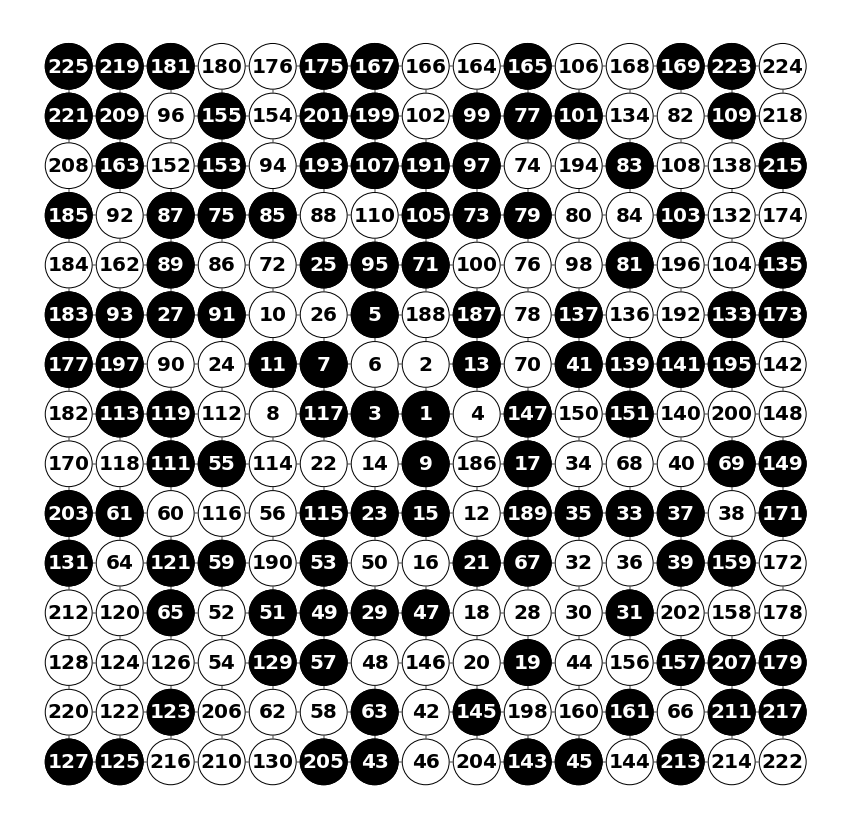

In [10]:
# Agent test
# agent(pt_softmax(m5policy_greedy, tau=1e-6))
# and m5agent_a must have same power!
m = Mock5()
m.play(agent(pt_softmax(m5aa.policy, tau=1e-6)), m5aa.agent,
       print_intermediate_state=False)
m.plot()
plt.show()

In [31]:
def test_agents(num_game, agent1, agent2):
  w1, w2 = 0, 0
  c1, c2 = 0, 0
  for i in range(num_game):
    g = Mock5(H, W)
    result = g.play(agent1, agent2,
                    print_intermediate_state=False, print_messages=False)
    if result == 1:
      w1 += 1
      c1 += len(g.history)
    elif result == 2:
      w2 += 1
      c2 += len(g.history)
  print("-- Test Result --")
  print("* Agent1 = {} \n* Agent2 = {}".format(
      fn_name(agent1), fn_name(agent2)))
  print("Total : {:5d}".format(num_game))
  print("A1 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w1, w1 / num_game, c1 / max(1, w1)))
  print("A2 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w2, w2 / num_game, c2 / max(1, w2)))

In [12]:
test_agents(10, m5rand.agent, m5aa.agent)

-- Test Result --
* Agent1 = agent-random 
* Agent2 = agent-analysis-based
Total: 10
A1 Win: 0 (0.000)
A2 Win: 10 (1.000)


### Additional Agents

현재 `Mock5`에 analysis를 바탕으로 하는
agent는 다음과 같은 것이 있습니다.

- `agent_analysis_basis (aa)`:
각 칸에 대해 분석하여 나온 점수합이 가장 큰 수를 선택합니다.
자신의 돌이 연결되는 경우에 비해 상대의 돌이 연결되는 경우는
점수에 $0.3$ 정도의 페널티를 줘서, 만약 남은 수가 같으면
자신이 이기는 쪽을 먼저 선택하도록 합니다.
최종적으로 랜덤하게 noise를 주기 때문에 완전히 같은 점수의
여러 수가 있으면 이들 중 임의로 하나를 고릅니다.
- `agent_analysis_defensive (ad)`:
`aa`와 거의 같지만, 상대방 연결에 대한 페널티가
$0.05$로 더 적어서 상대가 공격할 수단이 더 적을 때도
방어를 선호하게 됩니다.
- `agent_pt (pt)`
가장 적은 수로 게임이 끝나게 되는 수로 공격하거나, 그 수를
막습니다. 만약 1-2수에 끝나는 경우가 보이지 않으면
연결성분별로 점수를 부여해서 점수합으로 판단합니다.
기본적으로 각 길이에 해당하는 연결성분이 있는지만 확인하고
얼마나 있는지는 고려하지 않습니다.
만약 같은 등급의 연결성분이 여러개 있다면 임의로
하나를 선택합니다.
상대의 공격하는 수가 자신이 공격하는 수보다 같으면
공격을 우선합니다.
- `agent_df (df)`
`pt`와 거의 같지만, 서로 같은 수 내에 끝낼 수 있을 때,
자신이 1수로 게임을 끝내지 못할 것 같으면 방어를 우선합니다.

이 4개는 전부 `Analysis`를 기반으로 하며, tree search
등을 하지 않기 때문에, 수읽기를 하지 않는, 일종의 greedy한
정책을 사용합니다.

이들 각각을 $15 \times 15$ 오목판에서 
대결해보게 하면 대략 다음과 같은
승률을 확인할 수 있습니다.
(해당하는 행의 agent가
해당하는 열의 agent와 싸워서
이긴 승률입니다.
무승부는 0.5승으로 계산하였습니다.)

| wins |  aa  |  ad  |  pt  |  df  |
|:----:|:----:|:----:|:----:|:----:|
|  aa  |  -   | 0.38 | 0.73 | 0.72 |
|  ad  | 0.62 |  -   | 0.79 | 0.79 |
|  pt  | 0.27 | 0.21 |  -   | 0.37 |
|  df  | 0.28 | 0.21 | 0.63 |  -   |

위에서 알 수 있듯, `ad`가 전반적으로 가장 승률을 보여주며,
`pt`가 가장 약한 모습을 보여줍니다.
실제로 두는 모습을 보면 `ad`는 각 연결부에 가장 적극적으로
반응하는 것을 볼 수 있고,
반대로 `pt`는 연결이 되도록 두기는 하지만 상당히 랜덤하게
두는 것을 볼 수 있습니다.

일단은 가장 강한 상대인 `aa`나 `ad`를 상대로 학습을
하는 것이 좋을 수 있겠지만, 이 경우 Connect4에서 본
것처럼 과적합이 날 수 있는 관계로, 여기서는
위 4가지를 전부 섞은 `agent_mixed`를 사용합니다.

In [13]:
def agent_mixed(game):
  a = np.random.uniform()
  if a < 0.4: return m5aa.agent(game)
  elif a < 0.8: return m5ad.agent(game)
  elif a < 0.9: return m5pt.agent(game)
  else: return m5df.agent(game)
agent_mixed.name = 'agent-mixed-analysis-based'

`agent_mixed`는 각 수에 대해
비교적 높은 확률로 `aa`나 `ad`처럼
행동하되, 비교적 낮은 확률로 `pt`나 `df`와 같은
방식으로 모험을 합니다.

아래와 같이 `agent_mixed`를 테스트해보면,
`pt`, `df`보다는 강하되, `aa`, `ad`에 비해서는 조금
부족한 모습을 보입니다.

In [14]:
a = [m5aa, m5ad, m5pt, m5df]
for i in range(len(a)):
    test_agents(10, agent_mixed, a[i].agent)

-- Test Result --
* Agent1 = agent-mixed-analysis-based 
* Agent2 = agent-analysis-based
Total: 10
A1 Win: 3 (0.300)
A2 Win: 5 (0.500)
-- Test Result --
* Agent1 = agent-mixed-analysis-based 
* Agent2 = agent-analysis-defensive
Total: 10
A1 Win: 3 (0.300)
A2 Win: 6 (0.600)
-- Test Result --
* Agent1 = agent-mixed-analysis-based 
* Agent2 = agent-pt
Total: 10
A1 Win: 10 (1.000)
A2 Win: 0 (0.000)
-- Test Result --
* Agent1 = agent-mixed-analysis-based 
* Agent2 = agent-df
Total: 10
A1 Win: 6 (0.600)
A2 Win: 2 (0.200)


### Neural Network

In [15]:
class Flatten(nn.Module):
  def forward(self, x):
    if len(x.shape) == 3: return x.view(-1)
    else: return x.flatten(1, -1)

class FixedTempSoftmax(nn.Module):
  def __init__(self, dim, tau):
    super(FixedTempSoftmax, self).__init__()
    self.dim = dim
    self.tau = np.exp(tau)
  def forward(self, x):
    return nn.functional.softmax(x / self.tau, self.dim)

class TempSoftmax(nn.Module):
  def __init__(self, dim, tau=0):
    super(TempSoftmax, self).__init__()
    self.dim = dim
    self.tau = nn.Parameter(torch.tensor([tau], dtype=torch.float))
  def forward(self, x):
    return nn.functional.softmax(x / torch.exp(self.tau), self.dim)

In [16]:
## nn
def new_nn():
  net = nn.Sequential(
      # Conv01
      nn.Conv2d(3, 128, 3, padding='same'),
      nn.GELU(),
      # Conv02
      nn.Conv2d(128, 64, 3, padding='same'),
      nn.GELU(),
      # Conv03
      nn.Conv2d(64, 32, 3, padding='same'),
      nn.GELU(),
      # Conv04
      nn.Conv2d(32, 32, 3, padding='same'),
      nn.GELU(),
      # Conv05
      nn.Conv2d(32, 32, 3, padding='same'),
      nn.GELU(),
      # Conv06
      nn.Conv2d(32, 32, 3, padding='same'),
      nn.GELU(),
      # Conv07
      nn.Conv2d(32, 1, 5, padding='same'),
      nn.GELU(),
      # Flatten
      Flatten(),
      # Softmax
      FixedTempSoftmax(tau=0, dim=-1)
  ).to(device)
  return net

def init_nn():
  global policy, policy_backs
  policy = new_nn()
  policy_backs = []
  save_policy()

def save_policy():
  global policy_backs
  n = new_nn()
  n.load_state_dict(policy.state_dict())
  policy_backs = (policy_backs + [n])[-10: ]

In [17]:
def policy_model(net):
  def c(game):
    X = game.tensor(dtype=torch.float).unsqueeze(dim=0).to(device)
    with torch.no_grad():
      p = net(X)
    arr = p.squeeze().to('cpu').numpy()
    return arr
  c.name = 'model({:x})'.format(id(net))
  return c

In [18]:
def loss_fn(policy, v):
  # Original GD (minimization) : theta <- theta - alpha D J(theta)
  # In policy gradient (maximization) : theta <- theta + alpha v D log pi
  # => Negative log likelihood weighted by reward v
  return - (v * torch.log(1e-10 + policy)).mean()

In [19]:
class Stat:
  def __init__(self, n=0, w=0, l=0, d=0): self.n, self.w, self.l, self.d = n, w, l, d
  def dup(self):
    return Stat(self.n, self.w, self.l, self.d)
  def __sub__(self, other):
    return Stat(self.n - other.n, self.w - other.w, self.l - other.l, self.d - other.d)

- 학습을 할 때는 본래 기보 외에도
회전/대칭 변환을 한 기보 역시 학습에 사용합니다.
- 빨리 끝난 게임에 조금 더 가중치를 주어서
가능한 게임이 빨리 끝나도록 학습하도록 합니다.

In [32]:
# REINFORCE
def learn(
    agent1_gen,
    agent2_gen,
    opt,
    n_episode,
    n_epoch,
    gamma,
    batch_size,
    interval_stat
):
  epi = 0
  stat = Stat()
  last_stat = Stat()
  last_stat_epi = 0
  Xs, As, Vs = [], [], []
  for epi in range(n_episode):
    # Run Game
    game = Mock5(H, W)
    a1 = agent1_gen(epi)
    a2 = agent2_gen(epi)
    result = game.play(a1, a2,
                       print_intermediate_state=False,
                       print_messages=False)
    # Make reward
    stat.n += 1
    if result == 0: stat.d += 1
    elif result == 1: stat.w += 1
    else: stat.l += 1
    w = 3 - game.player
    reward = 1 + 9 / len(game.history) if result != 0 else 0.3
    # Append to Batch
    tr_games = []
    for f in range(2):
      for r in range(4):
        tr_games.append(game.replay(angle=r, flip=f))
    for t in range(len(game.history)):
      reward *= gamma
      for i in range(8):
        g = tr_games[i]
        a = g.history[-1]
        g.undo()
        if g.player == w:
          Xs.append(g.tensor(player=w))
          As.append(a)
          Vs.append(reward)
    # If batch is full enough, perform gradient ascent
    if len(Xs) >= batch_size:
      # Tensor-fy
      X = torch.stack(Xs).to(device)
      A = torch.tensor(As).unsqueeze(dim=1).to(device)
      V = torch.tensor(Vs, dtype=torch.float).to(device)
      Xs, As, Vs = [], [], []
      # Learn
      loss_list = []
      for e in range(n_epoch):
        opt.zero_grad()
        pi_s = policy(X)
        pi_sa = pi_s.gather(1, A).squeeze(dim=1)
        loss = loss_fn(pi_sa, V)
        loss_list.append(loss.mean().item())
        loss.backward()
        opt.step()
      # Print status
      if epi - last_stat_epi >= interval_stat:
        save_policy()
        print("----------")
        print("Ep #{:<6d} Loss {:13.10f} -> {:13.10f}".format(
          epi, loss_list[0], loss_list[-1]))
        print("  Win Rate {:8.4f}% ({}w + {}d + {}l = {})".format(
            100 * (stat.w + stat.d * 0.5) / stat.n,
            stat.w, stat.d, stat.l, stat.n))
        dstat = stat - last_stat
        print("   WR Diff {:8.4f}% ({}w + {}d + {}l = {})".format(
            100 * (dstat.w + dstat.d * 0.5) / dstat.n,
            dstat.w, dstat.d, dstat.l, dstat.n))
        test_agents(10, agent1_gen(epi), m5rand.agent)
        test_agents(10, agent1_gen(epi), m5pt.agent)
        last_stat = stat.dup()
        last_stat_epi = epi

### Learning

학습의 시간 제한은 (Colab 등 환경의 문제로) 최대 1시간으로
염두하였고, 아래에서는 대략 1시간이 되기 전인 15000 게임을
끝낸 뒤에 학습을 중단하였습니다.

In [33]:
def run():
  init_nn()

  agent1 = lambda e: agent(policy_model(policy))
  agent2 = lambda e: agent_mixed
  #opt = optim.Adam(policy.parameters(), lr=1e-4, weight_decay=1e-6)
  opt = optim.SGD(policy.parameters(),
                  lr=1e-2,
                  momentum=0.8,
                  weight_decay=1e-6)

  learn(
      agent1_gen = agent1,
      agent2_gen = agent2,
      opt = opt,
      n_episode = 100000,
      n_epoch = 2,
      gamma = 0.995,
      batch_size = 400,
      interval_stat = 500)
run()

----------
Ep #504    Loss  7.2813405991 ->  7.0667395592
  Win Rate   0.0000% (0w + 0d + 505l = 505)
   WR Diff   0.0000% (0w + 0d + 505l = 505)
-- Test Result --
* Agent1 = stochastic(model(7f7f97d73810)) 
* Agent2 = agent-random
Total :    10
A1 Win:    10 (1.000) (avg.mov   37.6)
A2 Win:     0 (0.000) (avg.mov    0.0)
-- Test Result --
* Agent1 = stochastic(model(7f7f97d73810)) 
* Agent2 = agent-pt
Total :    10
A1 Win:     0 (0.000) (avg.mov    0.0)
A2 Win:    10 (1.000) (avg.mov   14.2)
----------
Ep #1010   Loss  7.2661237717 ->  7.1276068687
  Win Rate   0.0000% (0w + 0d + 1011l = 1011)
   WR Diff   0.0000% (0w + 0d + 506l = 506)
-- Test Result --
* Agent1 = stochastic(model(7f7f97d73810)) 
* Agent2 = agent-random
Total :    10
A1 Win:    10 (1.000) (avg.mov   40.6)
A2 Win:     0 (0.000) (avg.mov    0.0)
-- Test Result --
* Agent1 = stochastic(model(7f7f97d73810)) 
* Agent2 = agent-pt
Total :    10
A1 Win:     0 (0.000) (avg.mov    0.0)
A2 Win:    10 (1.000) (avg.mov   12.5)
--

KeyboardInterrupt: ignored

## Evaluation

3213초 (약 53분)동안 15000개 가량의 게임을 진행하며
policy gradient로 학습을 하였으며,
최종 누적 승률은 15062 게임 중 946번으로 6.3%로 마무리되었
습니다.

학습 중간중간에 약 500 게임마다 최근 500 게임의 승률을
기록하였는데, 이 중 Ep \#14560에는
500번의 게임 중 97번 승리하여 약 19.4%의 구간 승률을
기록하였습니다.

Evaluation 중에는 `pt`와의 대결도 포함되어 있었으며,
Ep \#11557에서
최대 60%의 승률을 보였습니다.
(단, 이 경우에는 샘플이 너무 작아 정확도가 보장되지 않습니다.)

학습 중 `agent_mixed`와의 첫 승리는 학습이 약
27% 진행되었을 때인 Ep \#4033에서 처음으로 나타났습니다.

학습 중 `agent_random`과의 테스트에서
학습이 약 50% 진행되었을 때인 Ep \#7546에서부터
`agent_random`을 평균 10수에 이기며
거의 최적의 수를 두는 것을 확인할 수 있습니다.

아래는 `pt`와 싸울 경우 model이 승리하는 경우의
기보입니다.
(흑돌: `pt`, 백돌 `policy network`)

 [ Turn  98 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E
--+------------------------------
0 | . . . . . . . . . . . . . . .
1 | . . . . . . . . . O . . . . .
2 | . . . . O O X O . O X X . . .
3 | . . O X X O X O X X O . O . .
4 | . . O X O O X X O O O O X O .
5 | . O X O O X O X O . O . X . .
6 | X X X X O . . . X O . X X . .
7 | O . O . X X X O X X X O X . .
8 | . . . . . O X O . X O . X . .
9 | . . . . O . X . O X X . . . .
A | . . . . . . O X O X X O X . .
B | . . . . . X O X O O X X . . .
C | . . O X O O . X X O X . O . .
D | . . . . . . . O X O O . . . .
E | . . . . . . . . . . . . . . .
2p (stochastic(model(7f7f97d73810))) win!


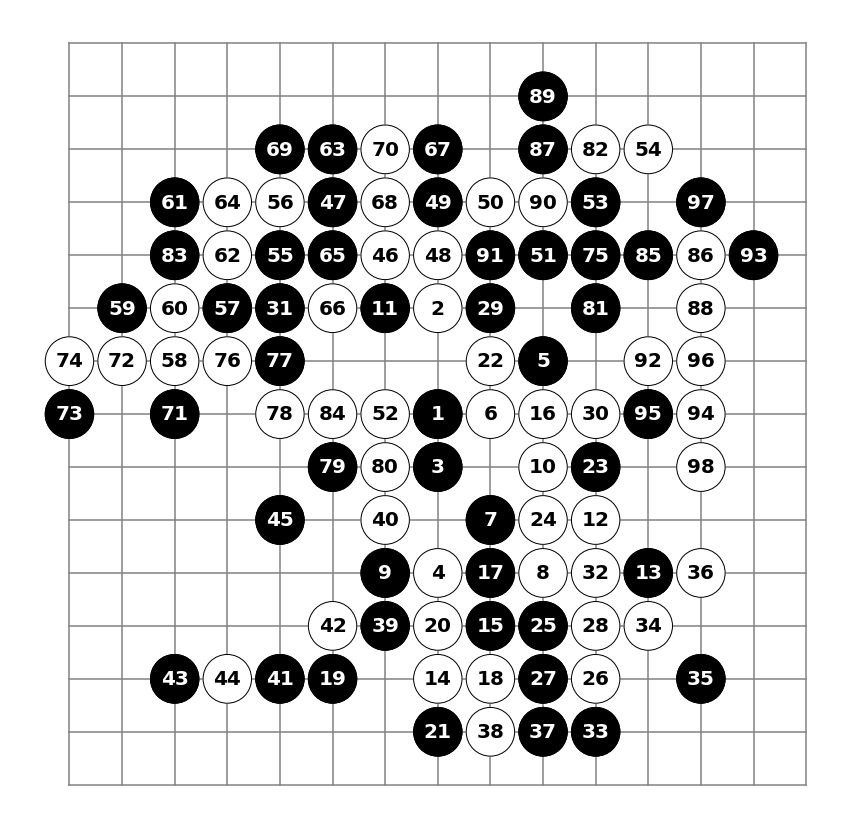

In [38]:
m = Mock5(H, W)
m.play(m5pt.agent, agent(policy_model(policy)), print_intermediate_state=False)
m.plot()
plt.show()

복기를 해봤을 때 다음과 같은 생각을 해볼 수 있습니다.

- CNN만을 사용하여 절대적인 좌표와 무관하게 판단하여 그런지,
처음 2, 4번 수가 이해하기 쉽지 않게 두어진 것을 볼 수 있습니다.
- 6번이나 80번 수처럼 상대 돌 사이에서 상대 연결을 끊는 수를
종종 두는 것을 볼 수 있습니다.
- 상대방이 4목을 만든 것을 찾아볼 수 없는데,
원래 상대가 된 analysis 기반 agent들이 마땅한 수가 없으면
상대방 공격을 적극적으로 끊는 것을 받아들인 것으로
추정됩니다.
때문에 연결을 이어나가기보다는 막는 것에 집중하는 경향이 보입니다.
- 어느 정도 고려를 하고 두는지는 모르겠지만,
94번 수부터 4-열린3을 만들어서 실수 없이
게임을 끝내는 것을 보면 두었을 때 유리한 위치를
어느 정도 파악하는 것을 볼 수 있습니다.

아래에서는 각각의 agent와의 승률을 확인합니다.

In [39]:
a = [m5aa, m5ad, m5pt, m5df]
for i in range(len(a)):
    test_agents(40, agent(policy_model(policy)), a[i].agent)

-- Test Result --
* Agent1 = stochastic(model(7f7f97d73810)) 
* Agent2 = agent-analysis-based
Total :    40
A1 Win:     8 (0.200) (avg.mov   57.9)
A2 Win:    32 (0.800) (avg.mov   55.5)
-- Test Result --
* Agent1 = stochastic(model(7f7f97d73810)) 
* Agent2 = agent-analysis-defensive
Total :    40
A1 Win:     8 (0.200) (avg.mov   44.4)
A2 Win:    32 (0.800) (avg.mov   56.7)
-- Test Result --
* Agent1 = stochastic(model(7f7f97d73810)) 
* Agent2 = agent-pt
Total :    40
A1 Win:    19 (0.475) (avg.mov   36.7)
A2 Win:    21 (0.525) (avg.mov   52.8)
-- Test Result --
* Agent1 = stochastic(model(7f7f97d73810)) 
* Agent2 = agent-df
Total :    40
A1 Win:    14 (0.350) (avg.mov   48.1)
A2 Win:    26 (0.650) (avg.mov   86.0)


각 agent와 게임을 진행하였을 때,
분석 점수를 바탕으로 한 `aa`, `ad`와는 약 20%의 승률을
보여주며, `pt`와는 48% 가량, `df`와는 35% 가량의 승률을
보입니다.

In [40]:
# Play with Me!
m = Mock5(H, W)
m.play(agent(policy_model(policy)))

 [ Turn   0 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E
--+------------------------------
0 | . . . . . . . . . . . . . . .
1 | . . . . . . . . . . . . . . .
2 | . . . . . . . . . . . . . . .
3 | . . . . . . . . . . . . . . .
4 | . . . . . . . . . . . . . . .
5 | . . . . . . . . . . . . . . .
6 | . . . . . . . . . . . . . . .
7 | . . . . . . . . . . . . . . .
8 | . . . . . . . . . . . . . . .
9 | . . . . . . . . . . . . . . .
A | . . . . . . . . . . . . . . .
B | . . . . . . . . . . . . . . .
C | . . . . . . . . . . . . . . .
D | . . . . . . . . . . . . . . .
E | . . . . . . . . . . . . . . .
row-col (e.g. 3a, 77) ; 'gg' ; 'undo' > 77
 [ Turn   1 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E
--+------------------------------
0 | . . . . . . . . . . . . . . .
1 | . . . . . . . . . . . . . . .
2 | . . . . . . . . . . . . . . .
3 | . . . . . . . . . . . . . . .
4 | . . . . . . . . . . . . . . .
5 | . . . . . . . . . . . . . . .
6 | . . . . . . . . . . . . . . .

2

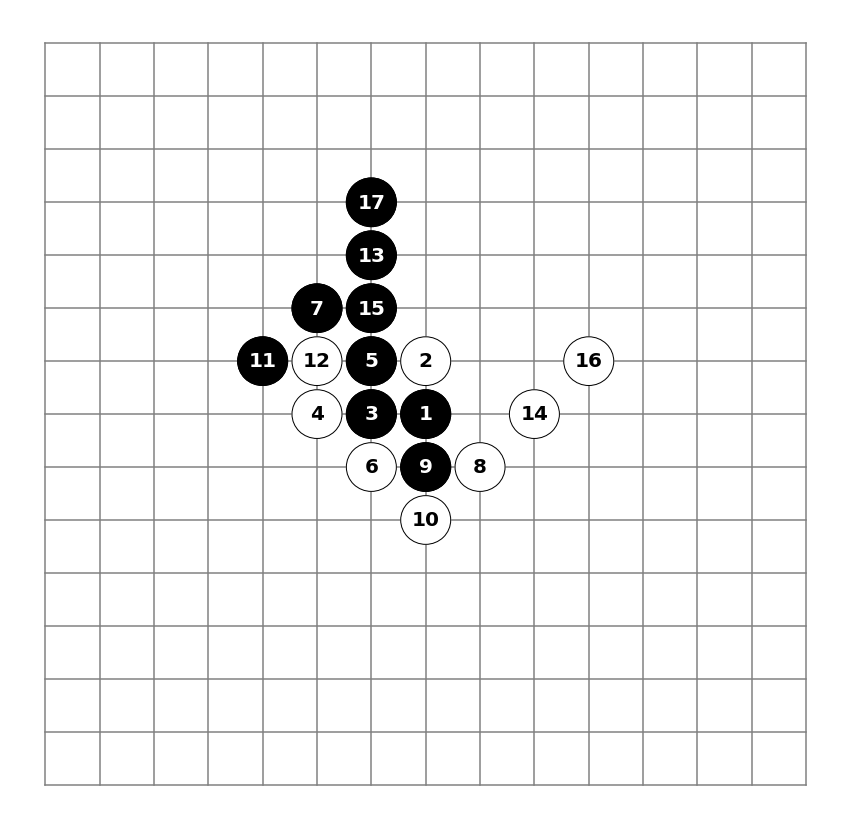

In [41]:
m.plot()

위 기보는 학습된 agent와 제가 직접 오목을 둔 기보입니다.
7번 수와 같이 공격을 했을 때 8번 수처럼 방어한다든가,
10번 수처럼 연결하는 것을 볼 수 있지만,
13, 15번 같은 수를 방어하지 않고 자신의 공격 수를 이어가는
것을 볼 수 있습니다.

위 결과들로 봤을 때,
오목은 학습 과정에서 다른 agent의 도움을 받아
policy gradient method를 사용하면
15000번의 게임으로도 매우 초보적인 수준에서의 게임 진행이
가능하다는 것을 확인할 수 있습니다.

## 고찰

### 학습 속도

처음에 이기고자 하였던 목표는 `agent_analysis_based`,
즉, 여기서의 `aa` 입니다.
현재는 약 20%의 승률을 보여주고 있지만,
학습 자체가 linear하게 성장하는 것이 아닌, local
optimum에서 박차고 올라갈 때만 변동이 보이는 것을 보아
50% 이상의 승률까지 올리는데 얼마나 긴 시간이 필요할지 알기
힘듭니다.

현재는 15000 게임 중 처음 1/3을 진행하고 나서 0%의
승률을 탈출하였고, 이후 1/3을 진행하고 나서야 구간 승률
10%를 달성하였습니다. 이런 식으로 선형적으로 증가한다고 해도
50%를 달성하기 위해서는 35000 게임, 즉, 3시간 가량을
학습에 써야 하며, 그 이상으로 넘어가기 위해서는 더 많은
시간이 필요할 것입니다.

현재 실험 환경이
1시간 이상 진행하기 어려운 만큼,
여러가지 실험을 해보려면
지금보다 훨씬 더 짧은 시간 안에 학습을 완수할 필요가 있습니다.

현재는 학습 과정을 처음에 승률 0%에서
머무는 부분과 그 이후로 크게 두 부분으로 나눠볼 수 있을
것입니다.
이 두 부분에는 약간의 차이가 있는데,
승률 0%인 부분에서는 자신의 행동에서 배울 것이 그다지 없다는
것입니다.
현재 학습 방법은 게임이 끝난 다음에, policy를
승자가 했던 행동의 확률이 높아지도록 학습을 합니다.
다르게 말하자면,
게임에서 이긴 사람의 수를 보며 '나중에 저 수는 따라해야겠다'고
하지만, 진 사람의 수를 보며 '저 수는 따라하지 말아야겠다'라고
생각하지는 않는다는 것입니다.
그렇다면 어차피 자신의 수를 보며 학습하지 않는다면
다른 사람의 게임을 보며, 이기는 사람의 수를 배우는 것이
낫지 않을까 생각해볼 수 있습니다.

실제로 인공신경망의 계산이 만만치 않게 오래 걸리기 때문에
처음에 기보를 넣고 지도학습 하는 방식을 쓰면
좋지 않을까 생각합니다.


### Convolutional v.s. Dense

이번 테스트로 알게 된 사실이 하나 더 있다면, covolutional
layer와 activation으로 7층을 쌓는 것으로도 적어도
알고리즘을 상대할 때는
괜찮은 결과를 보였다는 것입니다.

현재는 처음에는 kernel size 3으로 6개의 layer, 이후에는
kernel size 5인 하나의 layer를 사용하므로, 현재
receptive field의 반경은 9입니다.
즉, 정가운데의 칸에서는 $15\times 15$ 칸을 모두
커버하는 것이 가능하지만, 한쪽 끝에서는 오직 $10 \times 10$
크기의 칸과 zero padding을 통해 판단을 내려야 합니다.

다행히 오목은 돌은 인접하게 연결하여 승리하다보니, 이 정도의
receptive field로도 괜찮은 것 같지만, 만약 판이 더
커지게 되거나, 단순히 인접한 칸만으로 승리를 확인하지
못하는 경우가 생긴다면 이 방법으로는 무리가 있을 것입니다.

그렇다고 오목이 CNN으로만 모두 해결되는 것도 아닙니다.
예를 들어서 오목에서 첫 수는 천원, 두번째 수는 바로
인접한 칸에 두는 것이 보통입니다만, 만약 receptive field가
오목판보다 너무 작으면, 바둑판 중앙 근처의 모든 칸들이
같은 값을 가지게 되는 문제가 생기며,
receptive field가 충분히 크더라도
위치 정보 없이 가장자리의 zero padding으로 거리를
식별해야 하는 문제가 생깁니다.

이 때문에 결국에는 출력단에 dense layer를 사용하는 것이
적절한데, 이 경우에는 반대로 각 판마다 CNN의 결과를
다른 가중치로 사용하게 되므로, 각 위치마다 별도로
weight를 학습할 필요가 생길 것입니다.
다르게 말하자면, 사실상 같은 수인데도, 대칭의 위치에 있거나
평행이동 되어 있어서 전혀 다른 대응을 할 수 있다는 것입니다.

이 dense layer의 유무가 실제 학습 시간과 결과물에
얼마나 영향을 미치냐는 추후 실험을 할 필요가 있습니다.